In [1]:
#import required libraries
import html
import string
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#load facebook dataset: Australian cosmetics company facebook page
df = pd.read_csv("https://raw.githubusercontent.com/multidis/hult-social-media-analytics/main/data/brand_posts.csv")
df

,created_time,message,type,story,likes_count,comments_count,shares_count,love_count,haha_count,wow_count,sad_count,angry_count,comments
0,2012-06-20 15:12:38,"Ummm, yum! What would be in your ULTIMATE naug...",photo,Australis Cosmetics with Evalyn McGregor-Koch ...,715,47,46,0.0,0.0,0.0,0.0,0.0,that looks awesome Icecream with crushed oreo....
1,2012-06-21 15:09:46,Click 'like' if you worry about that too! <3 <3,photo,NaN,1103,8,80,0.0,0.0,0.0,0.0,0.0,:\ true. i agree I just moved and I am particu...
2,2012-06-22 10:41:36,Seems like some celebs can get away with any h...,photo,NaN,161,12,2,0.0,0.0,0.0,0.0,0.0,blonde her eye colour is different Way better ...
3,2012-06-22 15:37:04,We absolutely adore our bling here at Australi...,photo,NaN,30,0,0,0.0,0.0,0.0,0.0,0.0,NaN
4,2012-06-25 10:26:10,You know you want to... :P,photo,Australis Cosmetics with Evalyn McGregor-Koch ...,117,0,6,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2039,2017-01-08 17:00:00,Are you a porcelain princess who just can�t fi...,photo,NaN,150,70,4,11.0,0.0,0.0,0.0,1.0,Yes but I also have such an intense red tone i...
2040,2017-01-09 19:30:00,Blend Velourlips NY-Cee and Doo-Bai to achieve...,photo,NaN,35,1,0,0.0,0.0,0.0,0.0,0.0,She looked gorgeous <ed><U+00A0><U+00BD><ed><U...
2041,2017-01-10 09:30:00,FREE brush alert! To help you start the year w...,photo,NaN,40,4,1,0.0,0.0,1.0,0.0,0.0,I have this and it's honestly the best brush e...
2042,2017-01-15 16:30:00,Add some glow to your look with the High Life ...,photo,NaN,24,2,1,1.0,0.0,0.0,0.0,0.0,These are the best! But bring back the pan sti...


In [3]:
#test check: post text
df['message'][10]

"Congrats to our lucky winners! The three of you have won our latest competition... Which means there's a $100 Nicole Fendel Jewellery online store gift voucher and a Jumbo Bronzer headed your way! We're a bit jealous ;)"

In [4]:
#test check : comments (combined)
df['comments'][10]

"I am so thrilled!! THANK YOU THANK YOU THANK YOU AUSTRALIS X congrats all! You are very welcome, Alanis! xx Thank you so much Australis!!! So excited xx Hi Cat! You're welcome :) Tell us what you pick up from Nicole Fendel Jewellery when you get your prize! xx Just received my gorgeous Sandstone Turquoise Ring from Nicole Fendel Jewellery Thanks so much!!"

In [5]:
#test check : count of comment
df['comments_count'][10]

7

In [6]:
#total likes, shares, and comments count for each post
df[['likes_count', 'shares_count', 'comments_count']]

,likes_count,shares_count,comments_count
0,715,46,47
1,1103,80,8
2,161,2,12
3,30,0,0
4,117,6,0
...,...,...,...
2039,150,4,70
2040,35,0,1
2041,40,1,4
2042,24,1,2


In [7]:
#some posts were loved by many users
df['love_count'].max()

92.0

In [8]:
#occasional users were angried by some posts
df['angry_count'].max()

2.0

In [9]:
#types of post(1)
df["type"].unique()

array(['photo', 'video', 'link', 'status'], dtype=object)

In [10]:
#iterate over entry post and print how many times each one occurs in the dataset
for tp in df["type"].unique():
    ntp = len(df[df["type"] == tp])
    print(f"type {tp} occurs {ntp} times")

type photo occurs 1967 times
type video occurs 42 times
type link occurs 20 times
type status occurs 15 times


In [11]:
#average shares count for each type of post(2)
for tp in df["type"].unique():
    like = df[df["type"] == tp]["shares_count"].mean()
    print(f"type {tp} shared {int(like)} times on average")

type photo shared 3 times on average
type video shared 0 times on average
type link shared 0 times on average
type status shared 0 times on average


In [12]:
#cleaning the text
stop_words = set(stopwords.words('english'))

def text_cleanup(s):
    # if not a string object, disregard
    if not isinstance(s, str):
        return ''
    
    s_unesc = html.unescape(re.sub(r"http\S+", "", re.sub('\n+', ' ', s)))
    s_noemoji = s_unesc.encode('ascii', 'ignore').decode('ascii')
    # normalize to lowercase and tokenize
    wt = word_tokenize(s_noemoji.lower())
    
    # filter word-tokens
    wt_filt = [w for w in wt if (w not in stop_words) and (w not in string.punctuation) and (w.isalnum())]
    
    # return clean string
    return ' '.join(wt_filt)

In [13]:
#add clean text column
df['message_clean'] = df['message'].apply(text_cleanup)
df

,created_time,message,type,story,likes_count,comments_count,shares_count,love_count,haha_count,wow_count,sad_count,angry_count,comments,message_clean
0,2012-06-20 15:12:38,"Ummm, yum! What would be in your ULTIMATE naug...",photo,Australis Cosmetics with Evalyn McGregor-Koch ...,715,47,46,0.0,0.0,0.0,0.0,0.0,that looks awesome Icecream with crushed oreo....,ummm yum would ultimate naughty treat
1,2012-06-21 15:09:46,Click 'like' if you worry about that too! <3 <3,photo,NaN,1103,8,80,0.0,0.0,0.0,0.0,0.0,:\ true. i agree I just moved and I am particu...,click worry 3 3
2,2012-06-22 10:41:36,Seems like some celebs can get away with any h...,photo,NaN,161,12,2,0.0,0.0,0.0,0.0,0.0,blonde her eye colour is different Way better ...,seems like celebs get away hair colour check n...
3,2012-06-22 15:37:04,We absolutely adore our bling here at Australi...,photo,NaN,30,0,0,0.0,0.0,0.0,0.0,0.0,NaN,absolutely adore bling australis hq nothing ma...
4,2012-06-25 10:26:10,You know you want to... :P,photo,Australis Cosmetics with Evalyn McGregor-Koch ...,117,0,6,0.0,0.0,0.0,0.0,0.0,NaN,know want p
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2039,2017-01-08 17:00:00,Are you a porcelain princess who just can�t fi...,photo,NaN,150,70,4,11.0,0.0,0.0,0.0,1.0,Yes but I also have such an intense red tone i...,porcelain princess cant find foundation light ...
2040,2017-01-09 19:30:00,Blend Velourlips NY-Cee and Doo-Bai to achieve...,photo,NaN,35,1,0,0.0,0.0,0.0,0.0,0.0,She looked gorgeous <ed><U+00A0><U+00BD><ed><U...,blend velourlips achieve perfect bold lip insp...
2041,2017-01-10 09:30:00,FREE brush alert! To help you start the year w...,photo,NaN,40,4,1,0.0,0.0,1.0,0.0,0.0,I have this and it's honestly the best brush e...,free brush alert help start year flawless face...
2042,2017-01-15 16:30:00,Add some glow to your look with the High Life ...,photo,NaN,24,2,1,1.0,0.0,0.0,0.0,0.0,These are the best! But bring back the pan sti...,add glow look high life highlighting powder ed...


In [14]:
#combine all post text entries
text_all = ' '.join(df['message_clean'])

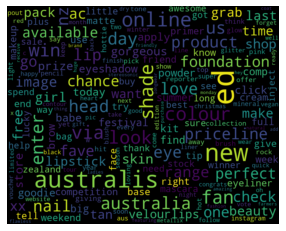

In [15]:
#keywords occurring throughout all of the posts(3)
wc = WordCloud(width=1000, height=800, max_font_size=110, collocations=False).generate(text_all)
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

In [17]:
#top-most commented entries(4)
df.sort_values(by='likes_count', ascending=False).head(20)

,created_time,message,type,story,likes_count,comments_count,shares_count,love_count,haha_count,wow_count,sad_count,angry_count,comments,message_clean
218,2012-11-12 16:09:18,Who's with us?! Hit LIKE if you agree! xx,photo,Australis Cosmetics with Bhaona Gosai and 7 ot...,3601,35,166,0.0,0.0,0.0,0.0,0.0,<3 it Except for those girls that like other g...,us hit like agree xx
27,2012-07-10 10:07:22,Click 'like' if you wish your make-up brush co...,photo,NaN,2997,54,13,0.0,0.0,0.0,0.0,0.0,HAHAH MINE IS :) although i am a MUA. no but i...,click wish brush collection looked like
130,2012-09-19 11:23:15,Apparently Ryan Gosling is coming to Australia...,photo,NaN,2496,33,143,0.0,0.0,0.0,0.0,0.0,Poor Stacey would be devastated to learn that ...,apparently ryan gosling coming australia click...
209,2012-11-08 09:40:34,'Share' this if you KNOW you're on your way to...,photo,NaN,2462,10,155,0.0,0.0,0.0,0.0,0.0,me to france. 4 me. an japan. an all ova europ...,know way somewhere awesome life
36,2012-07-16 17:15:59,"Is it just us, or did today seem SUPER long? C...",photo,Australis Cosmetics with Danielle Mcdonald and...,2329,76,116,0.0,0.0,0.0,0.0,0.0,awesome . yyyaammiiiii YUMMYyyyyyyyyyyyyyyyyyy...,us today seem super long click also think real...
17,2012-07-03 10:48:12,Hair idea for today! Randomly braid tiny secti...,photo,Australis Cosmetics with Evalyn McGregor-Koch ...,2095,29,71,0.0,0.0,0.0,0.0,0.0,I Want Her Hair! Its So Pretty! <3 thats sick ...,hair idea today randomly braid tiny sections h...
1764,2016-01-29 13:10:31,Did you guess? <ed><U+00A0><U+00BC><ed><U+00BD...,photo,NaN,1875,624,35,0.0,0.0,0.0,0.0,0.0,Amy Morley Emma Skinner Sarah Di Iorio yasss L...,guess ed ed ed ed ed ed
199,2012-11-01 17:53:15,"Too true, lovelies! xx",photo,NaN,1774,7,70,0.0,0.0,0.0,0.0,0.0,Amen to that nice pic :] yea hard hehe <3 :) T...,true lovelies xx
22,2012-07-05 15:59:10,Click like if you KNOW you shouldn't sleep wit...,photo,NaN,1556,35,7,0.0,0.0,0.0,0.0,0.0,"I never sleep with foundation on, but sometime...",click like know sleep sometimes way tired care
1893,2016-07-07 20:37:00,"Well, well, well - what do we have here? New t...",photo,NaN,1510,305,25,92.0,0.0,38.0,0.0,0.0,Laura McEvey BRUSHES!!! Haylee Mills <ed><U+00...,well well well new toys way fans find range on...


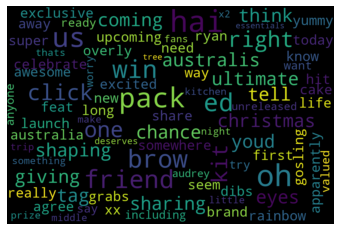

In [18]:
#top-shared posts: combined text(5)
text_shared = ' '.join(df.sort_values(by='shares_count', ascending=False)['message_clean'].head(10))
text_shared

#proceed generating a word cloud
wc = WordCloud(width=1200, height=800, max_font_size=110, collocations=False).generate(text_shared)
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()